# Time Series Analysis Project
### Part 4: Forecast trend data with seasonality and holidays using Facebook Prophet
### Written By Ali Chen

### Import Packages

In [55]:
from fbprophet import Prophet
import pandas as pd 
import numpy as np

#Holidays package keeps track of past and future holidays
import holidays
from datetime import date

In [56]:
#Find and specify holidays from one year
#For loop iterates through and returns key(date) and holiday name
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    print(date,name)
    goodholidays.append(name)

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


### Remove Irrelevant Holidays from Seasonality

In [57]:
#Specify which holidays to remove
#Note: I removed holidays that I believe are irrelevant to Hulu
#Note: I kept holidays where I anticipate an influx of users streaming Hulu such as Christmas, Thanksgiving, etc.
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Columbus Day")
goodholidays.remove("Veterans Day")
goodholidays.remove("Washington's Birthday")
goodholidays.remove("Memorial Day")

In [58]:
#Create new dataframe for holidays to use in Facebook Prophet
#holiday = name of holiday
#ds = datestamp of holiday
#lower_window = set parameters of holiday window (specifies when holiday begins)
#upper_window = set parameters of holiday window (specifies when holiday ends)
sales = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window'])

In [59]:
#Examine new blank dataframe
sales.head()

,holiday,ds,lower_window,upper_window


### Adding Holidays to Dataframe

In [60]:
#For loop to create an entry for each holiday in the dataframe
#Note: Can add more holidays to this for loop (must be a holiday that we can be predicted ahead of time)
for year in range(2014,2021): 
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window= 0
        upper_window= 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            #print(dayoftheweek)
            #print(date,name)
            if dayoftheweek == 0:
                lower_window = -2 #specifying when to start the holiday weekend (2 days before)
            if dayoftheweek ==1:
                lower_window= -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)] = [name, date, lower_window, upper_window] #use location function to create an index... 

In [61]:
#Examine first few rows of dataframe with holiday entries
sales.head()

,holiday,ds,lower_window,upper_window
0,New Year's Day,2014-01-01,0,0
1,Independence Day,2014-07-04,0,2
2,Labor Day,2014-09-01,-2,0
3,Thanksgiving,2014-11-27,0,3
4,Christmas Day,2014-12-25,0,3


In [62]:
#Import Google Trends Data for Hulu
hulu = pd.read_csv('hulu.googletrends.csv', parse_dates=['period'])

In [63]:
#Examine first few rows of Hulu data
hulu.head()

,Unnamed: 0,date,value,period,onedifvalue
0,0,Oct 07 2013,8315.286004,2013-10-07,NaN
1,1,Oct 08 2013,4946.639643,2013-10-08,-3368.646360
2,2,Oct 09 2013,4251.535654,2013-10-09,-695.103989
3,3,Oct 10 2013,7202.183136,2013-10-10,2950.647481
4,4,Oct 11 2013,7357.478661,2013-10-11,155.295525


In [64]:
#Initiate Prophet dataframe
prophetdataframe = pd.DataFrame()

In [65]:
#Specify parameters to Prophet
#ds = datestamp
#y = value
prophetdataframe['ds'] = hulu['period']
prophetdataframe['y'] = hulu['value']

In [66]:
#Examine first few rows of Prophet dataframe
prophetdataframe.head()

,ds,y
0,2013-10-07,8315.286004
1,2013-10-08,4946.639643
2,2013-10-09,4251.535654
3,2013-10-10,7202.183136
4,2013-10-11,7357.478661


### Initiate Facebook Prophet Model with Holidays

In [67]:
#Model = Prophet
m = Prophet(holidays=sales)

In [68]:
#Including more holidays from specified country (US)
m.add_country_holidays(country_name='US')

In [69]:
#Fit Prophet dataframe to Prophet model with fit() functionality
m.fit(prophetdataframe)

#Ignore warning message below (does not effect outcome of model)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
#Print name of holidays
print(m.train_holiday_names)

0                  New Year's Day
1                Independence Day
2                       Labor Day
3                    Thanksgiving
4                   Christmas Day
5     Martin Luther King, Jr. Day
6           Washington's Birthday
7                    Memorial Day
8                    Columbus Day
9                    Veterans Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object


In [71]:
#Create predictions for next calendar year
#Periods = 365 days (in one year)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

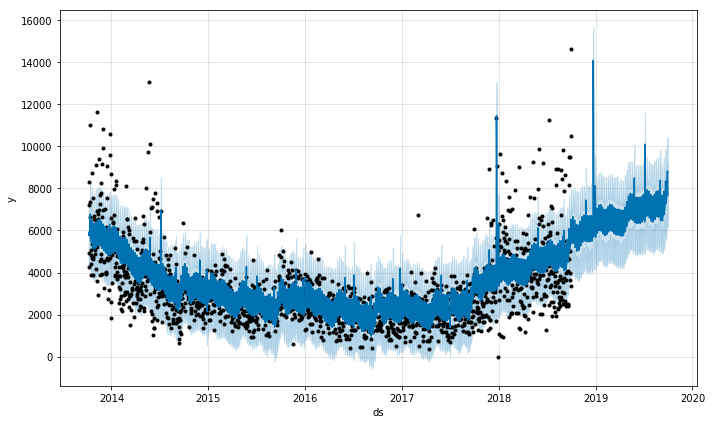

In [72]:
#Plot forecast predictions for next calendar year
#Shaded blue on right hand side of the graph is the forecast
fig1 = m.plot(forecast)

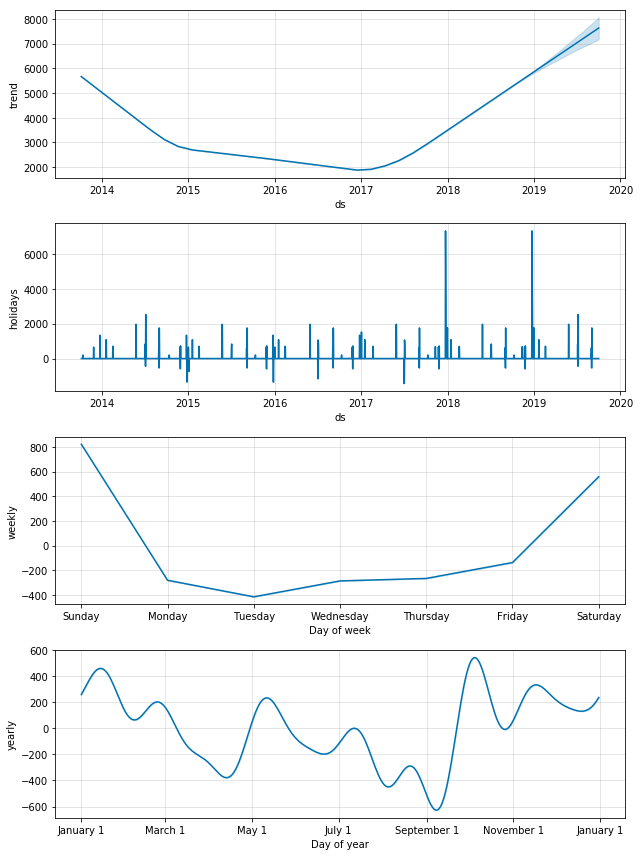

In [73]:
#Plot components of forecast model
fig2 = m.plot_components(forecast)

In [74]:
#Download forecast data to CSV
forecast.to_csv('forecast.csv')

### Initiate Facebook Prophet Model with Residuals

In [75]:
#Model = Predict
erroranalysis = m.predict(prophetdataframe)

In [76]:
#Add up residuals/errors observed each day

#Specify observed values from Y variable
erroranalysis['value'] = prophetdataframe['y']
#Create residuals column (actual observed value - predicted value)
erroranalysis['residuals']= erroranalysis['value'] - erroranalysis['yhat']
#Create absolute value of residuals column using abs() function
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

In [77]:
#Examine first few rows of "erroranalysis" dataframe
erroranalysis.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresiduals
0,2013-10-07,5664.980220,4351.596618,7368.764356,5664.980220,5664.980220,0.0,0.0,0.0,0.0,...,526.233177,526.233177,526.233177,0.0,0.0,0.0,5911.834342,8315.286004,2403.451661,2403.451661
1,2013-10-08,5657.581073,4397.643665,7379.248371,5657.581073,5657.581073,0.0,0.0,0.0,0.0,...,507.524935,507.524935,507.524935,0.0,0.0,0.0,5751.717699,4946.639643,-805.078055,805.078055
2,2013-10-09,5650.181926,4416.827434,7311.058024,5650.181926,5650.181926,0.0,0.0,0.0,0.0,...,483.095583,483.095583,483.095583,0.0,0.0,0.0,5848.501751,4251.535654,-1596.966096,1596.966096
3,2013-10-10,5642.782780,4335.142169,7329.917173,5642.782780,5642.782780,0.0,0.0,0.0,0.0,...,453.695482,453.695482,453.695482,0.0,0.0,0.0,5831.769649,7202.183136,1370.413487,1370.413487
4,2013-10-11,5635.383633,4466.460451,7434.108021,5635.383633,5635.383633,0.0,0.0,0.0,0.0,...,420.153599,420.153599,420.153599,0.0,0.0,0.0,5919.324444,7357.478661,1438.154217,1438.154217


In [78]:
#Create new variable "total_error" which is sum of absolute value of residuals
total_error = erroranalysis['absoluteresiduals'].sum()
total_error
#total_error = 1539973.0788011206

1539973.0788011206

In [79]:
#Average prediction mean error = 845 units
#Note: on average, by day, I am off by 845 Google Trend Units
mean_error = print(total_error/len(erroranalysis))
mean_error
#mean_error = 845.6743980236796

845.6743980236796


In [80]:
#Examine top 10 days with largest residuals
#Index(row number): Number on far left of data output
#absoluteresiduals: column calculates how many units off the prediction is
print(erroranalysis.nlargest(10, 'absoluteresiduals'))

             ds        trend   yhat_lower   yhat_upper  trend_lower  \
229  2014-05-24  3973.613417  3140.150625  6172.279759  3973.613417   
1818 2018-09-29  5252.840208  4637.813500  7736.405909  5252.840208   
1735 2018-07-08  4715.761090  4044.957809  6985.505533  4715.761090   
53   2013-11-29  5272.825442  3879.283086  6912.555871  5272.825442   
33   2013-11-09  5420.808377  4805.042841  7618.826606  5420.808377   
1699 2018-06-02  4482.811111  3489.477131  6391.057448  4482.811111   
1553 2018-01-07  3538.069531  3290.822142  6190.300766  3538.069531   
1241 2017-03-01  1956.273349   340.835906  3414.854052  1956.273349   
1677 2018-05-11  4340.452791  2931.637045  5864.065417  4340.452791   
223  2014-05-18  4017.671988  3466.606883  6478.783807  4017.671988   

      trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
229   3973.613417            0.0                  0.0                  0.0   
1818  5252.840208            0.0                  0.0         

### Removing Outliers from Data

In [86]:
#Remove outliers from data to improve model prediction
#Dates removed are important dates to the Hulu brand (new product launch, positive news coverage, etc.)

#(2013-10-23): Hulu announces first free mobile videos
date = pd.to_datetime("2013-10-23")

#Set index parameters
theindex = prophetdataframe[prophetdataframe.ds == date].index

In [87]:
#Print index
print(theindex)

Int64Index([16], dtype='int64')


In [88]:
#Write over original data frame with same data frame but get rid of the index
prophetdataframe = prophetdataframe.drop(theindex)

In [92]:
#Repeat above process to remove the remaining outliers
#(2013-10-23): Hulu announces first free mobile videos
date = pd.to_datetime("2014-04-02")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([], dtype='int64')


In [93]:
#(2014-05-02): Hulu releases in-purchase ad to order Pizza Hut within the ad
date = pd.to_datetime("2014-05-02")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([207], dtype='int64')


In [94]:
#(2015-05-15): TV Show "Mindy Project" moves to Hulu after cancelled on Fox
date = pd.to_datetime("2015-05-15")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([585], dtype='int64')


In [95]:
#(2015-06-24): Hulu adds all 180 Seinfield episodes to streaming and recreated Seinfield apartment in NY installation
date = pd.to_datetime("2015-06-24")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([625], dtype='int64')


In [96]:
#(2015-08-30): Hulu lands new, big client "Epix"
date = pd.to_datetime("2015-08-30")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([692], dtype='int64')


In [97]:
#(2015-09-02): Hulu introduces commercial-free streaming plan for additional $4/per month
date = pd.to_datetime("2015-09-02")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([695], dtype='int64')


In [98]:
#(2016-05-04): Hulu announces live streaming TV for next year
date = pd.to_datetime("2015-05-04")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([574], dtype='int64')


In [99]:
#(2016-08-03): Time Warner Buys 10% stake at Hulu, valuing it at $5.8 billion
date = pd.to_datetime("2015-08-03")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([665], dtype='int64')


In [100]:
#(2016-08-08): Hulu ends free streaming service
date = pd.to_datetime("2015-08-08")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([670], dtype='int64')


In [101]:
#(2017-01-04): Hulu adds CBS to its streaming service
date = pd.to_datetime("2017-01-04")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1185], dtype='int64')


In [102]:
#(2017-04-26): Hulu's new TV show "Handmaid's Tale" creates headlines and news coverage
date = pd.to_datetime("2017-04-26")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1297], dtype='int64')


In [103]:
#(2017-05-03): Hulu launches live TV streaming
date = pd.to_datetime("2017-05-03")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1304], dtype='int64')


In [104]:
#(2017-07-25): Hulu is added to Nielsen's TV ratings
date = pd.to_datetime("2017-07-25")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1387], dtype='int64')


In [105]:
#(2017-09-07): Hulu partners with Spotify to offer bundle deal prices
date = pd.to_datetime("2017-09-07")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1431], dtype='int64')


In [106]:
#(2018-01-14): Hulu sets premier date for TV show "Handmaid's Tale" season 2
date = pd.to_datetime("2018-01-14")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1560], dtype='int64')


In [107]:
#(2018-02-07): Disney expected to lose $250 million on Hulu in 2018
date = pd.to_datetime("2018-02-07")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1584], dtype='int64')


In [108]:
#(2018-04-11): Hulu and Spotify launch discounted bundle for $12.99
date = pd.to_datetime("2018-04-11")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1647], dtype='int64')


In [109]:
#(2018-04-25): Season 2 of Hulu's TV Show "Handmaid's Tale" creates headlines and news coverage
date = pd.to_datetime("2018-04-25")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1661], dtype='int64')


In [110]:
#(2018-06-22): Uber driver in self-driving car crash was streaming Hulu show
date = pd.to_datetime("2018-06-22")
theindex = prophetdataframe[prophetdataframe.ds == date].index
print(theindex)
prophetdataframe = prophetdataframe.drop(theindex)

Int64Index([1719], dtype='int64')


In [113]:
#Summary output of dataframe
#Overall, 21 entries have been removed from the data including holidays and outliers
prophetdataframe.describe()

,y
count,1800.000000
mean,3116.311206
std,1708.598452
min,0.000000
25%,1998.573136
50%,2720.573209
75%,3748.953490
max,14630.786184
